In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('C:/Users/saide/Desktop/study/python_upskill/ml_algorithms/house_price.csv')

In [3]:
df

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06
...,...,...,...,...,...,...,...,...
995,3261,4,1,1978,2.165110,2,10,7.014940e+05
996,3179,1,2,1999,2.977123,1,10,6.837232e+05
997,2606,4,2,1962,4.055067,0,2,5.720240e+05
998,4723,5,2,1950,1.930921,0,7,9.648653e+05


In [4]:
df = df.drop_duplicates()
df = df.fillna(df.median(numeric_only=True))
df = df.select_dtypes(include=[np.number])

In [5]:
target_col = "House_Price"  
X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
df

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06
...,...,...,...,...,...,...,...,...
995,3261,4,1,1978,2.165110,2,10,7.014940e+05
996,3179,1,2,1999,2.977123,1,10,6.837232e+05
997,2606,4,2,1962,4.055067,0,2,5.720240e+05
998,4723,5,2,1950,1.930921,0,7,9.648653e+05


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
class RegressionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class RegressionTreeScratch:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features  # None, "sqrt", "log2", or int
        self.random_state = random_state
        self.root = None
        self._rng = np.random.default_rng(random_state)

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float).reshape(-1)
        self.n_features_ = X.shape[1]
        self.root = self._build_tree(X, y, depth=0)
        return self

    def predict(self, X):
        X = np.array(X, dtype=float)
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            np.unique(y).size == 1):
            return RegressionTreeNode(value=float(np.mean(y)))
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return RegressionTreeNode(value=float(np.mean(y)))
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return RegressionTreeNode(value=float(np.mean(y)))
        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return RegressionTreeNode(
            feature=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        feature_indices = self._get_feature_indices(n_features)
        best_mse = float("inf")
        best_feature = None
        best_threshold = None
        if np.var(y) == 0:
            return None, None
        for feature in feature_indices:
            x_col = X[:, feature]
            sort_idx = np.argsort(x_col)
            x_sorted = x_col[sort_idx]
            y_sorted = y[sort_idx]
            unique_vals = np.unique(x_sorted)
            if unique_vals.size == 1:
                continue
            y_prefix_sum = np.cumsum(y_sorted)
            y_prefix_sq_sum = np.cumsum(y_sorted ** 2)
            total_sum = y_prefix_sum[-1]
            total_sq_sum = y_prefix_sq_sum[-1]
            for i in range(1, n_samples):
                if x_sorted[i] == x_sorted[i - 1]:
                    continue
                left_n = i
                right_n = n_samples - i
                left_sum = y_prefix_sum[i - 1]
                left_sq_sum = y_prefix_sq_sum[i - 1]
                right_sum = total_sum - left_sum
                right_sq_sum = total_sq_sum - left_sq_sum
                left_var = (left_sq_sum / left_n) - (left_sum / left_n) ** 2
                right_var = (right_sq_sum / right_n) - (right_sum / right_n) ** 2
                weighted_mse = (left_n / n_samples) * left_var + (right_n / n_samples) * right_var
                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_feature = feature
                    best_threshold = (x_sorted[i - 1] + x_sorted[i]) / 2.0
        return best_feature, best_threshold

    def _get_feature_indices(self, n_features):
        mf = self.max_features
        if mf is None:
            k = n_features
        elif isinstance(mf, int):
            k = max(1, min(mf, n_features))
        elif mf == "sqrt":
            k = max(1, int(np.sqrt(n_features)))
        elif mf == "log2":
            k = max(1, int(np.log2(n_features)))
        else:
            raise ValueError("max_features must be None, 'sqrt', 'log2', or int")
        return self._rng.choice(n_features, size=k, replace=False)

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [10]:
class RandomForestRegressorScratch:
    def __init__(
        self,
        n_estimators=20,
        max_depth=6,
        min_samples_split=10,
        max_features="sqrt",
        random_state=42
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self._rng = np.random.default_rng(random_state)

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float).reshape(-1)
        n_samples = X.shape[0]
        self.trees = []
        for t in range(self.n_estimators):
            indices = self._rng.integers(0, n_samples, size=n_samples)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = RegressionTreeScratch(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features,
                random_state=int(self._rng.integers(0, 1_000_000_000))
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X):
        X = np.array(X, dtype=float)
        all_preds = np.array([tree.predict(X) for tree in self.trees])  # (n_trees, n_samples)
        return np.mean(all_preds, axis=0)

In [11]:
rf = RandomForestRegressorScratch(
    n_estimators=50,
    max_depth=8,
    min_samples_split=10,
    max_features="sqrt",
    random_state=42
)
rf.fit(X_train.values, y_train.values)
y_pred_rf = rf.predict(X_test.values)

In [12]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics")
print("MSE :", mse_rf)
print("RMSE:", rmse_rf)
print("MAE :", mae_rf)
print("R2  :", r2_rf)

Random Forest Regression Metrics
MSE : 4025388292.12032
RMSE: 63445.94779905427
MAE : 48236.43933608053
R2  : 0.9375510445874584


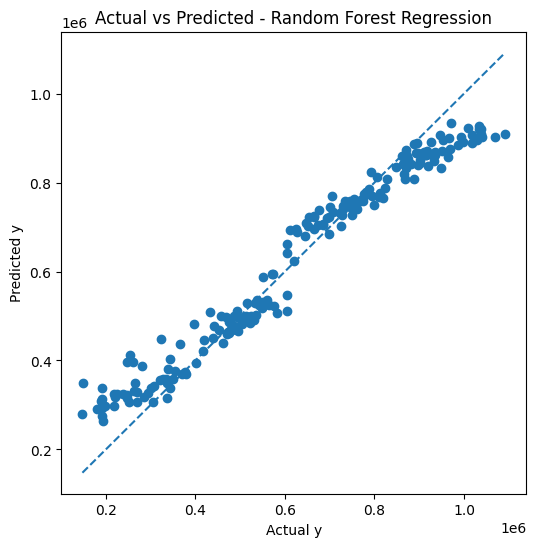

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.title("Actual vs Predicted - Random Forest Regression")
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.show()

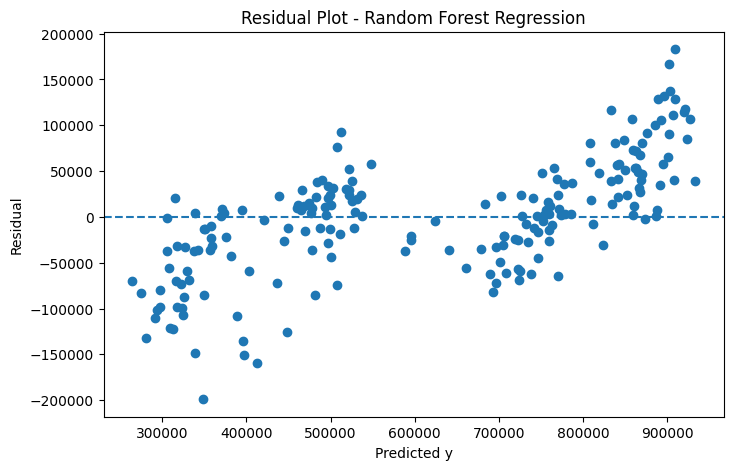

In [14]:
residuals_rf = y_test.values - y_pred_rf
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_rf, residuals_rf)
plt.axhline(0, linestyle='--')
plt.title("Residual Plot - Random Forest Regression")
plt.xlabel("Predicted y")
plt.ylabel("Residual")
plt.show()

In [16]:
rf_results = pd.DataFrame([{
    "Model": "Random Forest Regression (Scratch)",
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "MAE": mae_rf,
    "R2": r2_rf,
    "Trees": 20,
    "Max Depth": 8
}])
rf_results

,Model,MSE,RMSE,MAE,R2,Trees,Max Depth
0,Random Forest Regression (Scratch),4.025388e+09,63445.947799,48236.439336,0.937551,20,8
